In [1]:
# ipynb形式のライブラリのインポート
%run ./lib.ipynb

# 修正したモデルから卒論時に集計したデータを作成する

1. 表

| ベンチマーク名 | 平均誤差率(%) | コスト比(%) |
|---------|----------|---------|


2. 表

| ベンチマーク名 | 採用割合(最大MAPE(%), 最小MAPE(%)) |
|---------|----------------------------|
|         | モデル(1), モデル(2), ...        |


* 平均誤差率：大規模実行時の関数コール回数との比較
* MAPE：トレーニングデータとの比較

<Figure size 288x216 with 0 Axes>

Text(0.5, 0, '使用したプロファイル数')

Text(0, 0.5, '平均誤差率(%)')

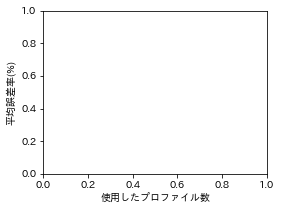

In [2]:
plt.figure(figsize=(4, 3))
plt.xlabel("使用したプロファイル数")
plt.ylabel("平均誤差率(%)")

In [3]:
# pd.get_option("display.max_columns")
# pd.get_option("display.max_rows")
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

[2, 3, 4, 5, 6, 7, 8, 9]

[353.585101963233,
 472.66554700445334,
 669.6651917170099,
 6.299840510366826,
 60.464972045314795,
 3.149920255183413,
 1.376534937823026,
 0.8565106279787753]

<Figure size 432x288 with 0 Axes>

Text(0.5, 0, '使用したプロファイル数[％]')

Text(0, 0.5, '平均絶対誤差率')

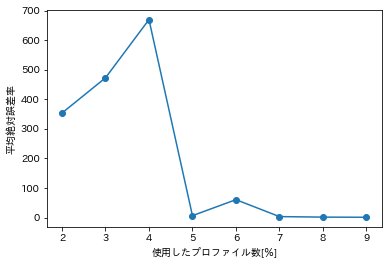

In [4]:
benchmark = "cg"
fix = "Class"
if benchmark == "bt" or benchmark == "sp":
    processes = processes_onlyBTSP
else:
    processes = processes_excludeBTSP
benchmarkClasses = ["A", "B", "C", "D"]
targetNumOfProcess = 256
fixedBenchmarkClass = "B"
fixedProcess = 64

# 引数の条件に合った生の実験データを取得する
DF = returnRawDFperBenchmark(Benchmark=benchmark, fix=fix, benchmarkClass=benchmarkClasses,
                             FixedProcess=fixedProcess, Processes=processes, FixedBenchmarkClass=fixedBenchmarkClass)
# 取得した生の実験データから NaN が含まれる関数の実験データを削除
noNaNDF = DF.dropna(how='any')
# noNaNDF

returnedCalculatedDF = return_calculatedDF(benchmark=benchmark, noNaNDF=noNaNDF,
                                           targetNumOfProcess=targetNumOfProcess, targetProblemSize=fixedBenchmarkClass, fix=fix)
# returnedCalculatedDF

# numOfData列の要素一覧を作成し、ソートされたリストを、listOfNumDataに格納する
listOfNumOfData = returnedCalculatedDF['numOfData'].tolist()
listOfNumOfData = sorted(list(set(listOfNumOfData)))
# listOfNumOfData


# 使用したプロファイル数をキー・最適モデルでの相対誤差の平均をバリューとした辞書を作成する
dictAverageRelativeErrorOfBestModel = {}
x = []
y = []
for numOfData in listOfNumOfData:
    # 使用したプロファイル数で抽出
    extractedPerNumOfProfileDF = returnedCalculatedDF[returnedCalculatedDF['numOfData'] == numOfData]
    meanDF = extractedPerNumOfProfileDF.mean()
    data = meanDF.at['relativeErrorOfBestModel']
    dictAverageRelativeErrorOfBestModel[numOfData] = data

x = list(dictAverageRelativeErrorOfBestModel.keys())
x
y = [dictAverageRelativeErrorOfBestModel[key] for key in x]
y

plt.figure()
plt.plot(x, y, marker='o')
plt.xlabel("使用したプロファイル数[％]")
plt.ylabel("平均絶対誤差率")

In [5]:
# benchmarksからbt, spを除外する
benchmarks = [benchmark for benchmark in benchmarks if benchmark !=
              'bt' and benchmark != 'sp']

In [6]:
# 集計した各ベンチマークごとにX/Y軸のデータを保持した辞書を返す
def returnDictForPlotPerNumOfUsedData(Benchmark=["cg"], fix="Class", benchmarkClass=["A", "B", "C", "D"], FixedProcess=64, Processes=[1, 2, 4, 8, 16, 32, 64, 128, 256], FixedBenchmarkClass="C"):
    # 実際に返す辞書
    returnDict = {}
    # 計算されたDFを保持するための辞書
    dictOfCalculatedDF = {}
    # プロットするためのデータを集計する
    for benchmark in benchmarks:
        DF = returnRawDFperBenchmark(Benchmark=benchmark, fix=fix, benchmarkClass=benchmarkClass,
                                     FixedProcess=FixedProcess, Processes=Processes, FixedBenchmarkClass=FixedBenchmarkClass)
        noNaNDF = DF.dropna(how='any')
        dictOfCalculatedDF[benchmark] = return_calculatedDF(
            benchmark=benchmark, noNaNDF=noNaNDF, targetNumOfProcess=256, targetProblemSize=FixedBenchmarkClass, fix=fix)

    # ベンチマークごとに集計する
    for benchmark in list(dictOfCalculatedDF.keys()):
        # numOfData列の要素一覧を作成し、ソートされたリストを、listOfNumDataに格納する
        valueCalculatedDF = dictOfCalculatedDF[benchmark]
        listOfNumOfData = valueCalculatedDF['numOfData'].tolist()
        listOfNumOfData = sorted(list(set(listOfNumOfData)))

        # 使用したプロファイル数をキー・最適モデルでの相対誤差の平均をバリューとした辞書を作成する
        dictAverageRelativeErrorOfBestModel = {}
        x = []
        y = []
        for numOfData in listOfNumOfData:
            # 使用したプロファイル数で抽出
            extractedPerNumOfProfileDF = valueCalculatedDF[valueCalculatedDF['numOfData'] == numOfData]
            meanDF = extractedPerNumOfProfileDF.mean()
            data = meanDF.at['relativeErrorOfBestModel']
            dictAverageRelativeErrorOfBestModel[numOfData] = data

        # プロットするにあたってX/Y軸に分ける
        x = list(dictAverageRelativeErrorOfBestModel.keys())
        y = [dictAverageRelativeErrorOfBestModel[key] for key in x]
        returnDict[benchmark] = {"x": x, "y": y}

    return(returnDict)


returnDictForPlotPerNumOfUsedData(Benchmark=benchmarks, fix="Class", benchmarkClass=[
                                  "A", "B", "C", "D"], FixedProcess=64, Processes=[1, 2, 4, 8, 16, 32, 64, 128, 256], FixedBenchmarkClass="C")

{'cg': {'x': [2, 3, 4, 5, 6, 7, 8, 9],
  'y': [506.88003200983024,
   588.1475455336396,
   504.6946921465946,
   21.33265764721618,
   41.29333925852622,
   18.182737392032767,
   23.016864485511334,
   15.032817136849353]},
 'ep': {'x': [2, 3, 4, 5, 6, 7, 8, 9],
  'y': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]},
 'ft': {'x': [2, 3, 4, 5, 6, 7, 8, 9],
  'y': [423983.2956719109,
   11.67279307487481,
   11.671379480474085,
   11.670919197057314,
   11.670636747822575,
   11.670454332716234,
   11.670330302458096,
   11.670242064504398]},
 'is': {'x': [2, 3, 4, 5, 6, 7, 8, 9],
  'y': [719611.6653453709,
   16.665435283895736,
   16.66571033856286,
   16.66591847036532,
   16.665729078109567,
   16.66574314083918,
   16.66573798941636,
   16.665737372415563]},
 'lu': {'x': [2, 3, 4, 5, 6, 7, 8, 9],
  'y': [184488.59374252838,
   21074.165315545037,
   323.666057113556,
   288.9696006676073,
   197.5676955176946,
   127.97837633130716,
   113.48802458120424,
   99.12151983229894]},
 'mg': 

In [7]:
# variablesToLearn = [1, 2, 4, 8, 16, 32, 64, 128]
# variablesToPredict = [256]
# fixedClassOrProcess = "Class"
# fixed = "C"

# 相対コストを返す関数(返り値の単位は％)
# variablesToLearn:予測に用いる説明変数のリスト ex1:[1,2,4,8], ex2:["A", "B", "C"]
# variablesToPreditct:予測したい説明変数のリスト ex1:[256], ex2:["D"]
# fixedClassOrProcess:"Class"or"Process"
# fixed:"C"
def returnRelativeCost(benchmark="cg", variablesToLearn=[1, 2, 4, 8, 16, 32, 64, 128], variablesToPredict=[256], fixedClassOrProcess="Class", fixed="C"):
    if fixedClassOrProcess == "Class":
        pass
    else:
        pass
    # 目標となる環境でのコスト
    targetCost = 0
    for variableToPredict in variablesToPredict:
        targetCost += variableToPredict * \
            return_ExecTime(benchmark=benchmark,
                            BenchmarkClass=fixed, Process=variableToPredict)
    # 予測するのに必要なコスト
    predictCost = 0
    for variableToLearn in variablesToLearn:
        predictCost += variableToLearn * \
            return_ExecTime(benchmark=benchmark,
                            BenchmarkClass=fixed, Process=variableToLearn)
    return 100 * predictCost / targetCost


dictTmp = returnDictForPlotPerNumOfUsedData(Benchmark=benchmarks, fix="Class", benchmarkClass=[
    "A", "B", "C", "D"], FixedProcess=64, Processes=[1, 2, 4, 8, 16, 32, 64, 128, 256], FixedBenchmarkClass="C")

In [8]:
tmpDF = pd.DataFrame()
for benchmark in benchmarks:
    listToLearn = [1, 2, 4, 8, 16, 32, 64, 128]
    listToPredict = [256]
    benchmark_x = dictTmp[benchmark]["x"]
    benchmark_y = dictTmp[benchmark]["y"]
    index = benchmark_x.index(len(listToLearn))
    MAPE = benchmark_y[index]
    relativeCost = returnRelativeCost(benchmark=benchmark, variablesToLearn=listToLearn,
                                      variablesToPredict=listToPredict, fixedClassOrProcess="Class", fixed="C")
    dictRowData = {"ベンチマーク名": benchmark, "平均絶対誤差率": int(10*MAPE)/10, "相対コスト": int(10*relativeCost)/10}
    iDF = pd.DataFrame.from_dict(dictRowData, orient='index').T
    tmpDF = tmpDF.append(iDF)
print(tmpDF.to_latex())

\begin{tabular}{llll}
\toprule
{} & ベンチマーク名 & 平均絶対誤差率 &  相対コスト \\
\midrule
0 &      cg &    23.0 &  713.8 \\
0 &      ep &     0.0 &  858.2 \\
0 &      ft &    11.6 &  535.8 \\
0 &      is &    16.6 &  449.2 \\
0 &      lu &   113.4 &  499.4 \\
0 &      mg &     5.7 &  444.7 \\
\bottomrule
\end{tabular}



Text(0.5, 0, '使用したプロファイル数[％]')

Text(0, 0.5, '平均絶対誤差率')

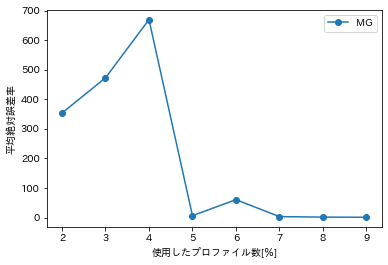

In [9]:
# 実際にプロットする
plt.plot(x, y, marker='o', label=benchmark.upper())
plt.legend()
plt.xlabel("使用したプロファイル数[％]")
plt.ylabel("平均絶対誤差率")

# print(f"fix={fix}, benchmarkClasses={benchmarkClasses}, fixedProcess={fixedProcess}, Processes={processes}, FixedBenchmarkClass={fixedBenchmarkClass}")
# print(f"targetNumOfProcess={targetNumOfProcess}, targetProblemSize={fixedBenchmarkClass}, fix={fix}")

In [10]:
DF = returnRawDFperBenchmark(Benchmark="mg", fix="Process", benchmarkClass=["A", "B", "C", "D"], Processes=[
                             1, 2, 4, 8, 16, 32, 64, 128, 256], FixedBenchmarkClass="B", FixedProcess=64)
DF.dropna(how='any')
DF

,A,B,C,D
Name,,,,
.TAU_application,1.000,1.000,1.000,1.000
ALLOC_SPACE,1.000,1.000,1.000,1.000
BUBBLE,444.219,444.219,529.125,612.562
COMM3,119.000,487.000,550.000,1483.000
COMM3_EX,35.000,147.000,168.000,459.000
GIVE3,661.500,2701.500,3079.500,8362.500
GIVE3_EX,15.000,63.000,63.000,153.000
INTERP,35.000,147.000,168.000,459.000
MG3P,5.000,21.000,21.000,51.000


,A,B,C,D
Name,,,,
.TAU_application,1.000,1.000,1.000,1.000
ALLOC_SPACE,1.000,1.000,1.000,1.000
BUBBLE,444.219,444.219,529.125,612.562
COMM3,119.000,487.000,550.000,1483.000
COMM3_EX,35.000,147.000,168.000,459.000
GIVE3,661.500,2701.500,3079.500,8362.500
GIVE3_EX,15.000,63.000,63.000,153.000
INTERP,35.000,147.000,168.000,459.000
MG3P,5.000,21.000,21.000,51.000
